<a href="https://colab.research.google.com/github/AnjaMirenska/tests/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sensordata20201109-153617_Getriebe1.csv to sensordata20201109-153617_Getriebe1.csv
User uploaded file "sensordata20201109-153617_Getriebe1.csv" with length 268767471 bytes


In [3]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
import logging
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM
from tensorflow.keras.layers import TimeDistributed, RepeatVector, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.models import Sequential
import time

In [6]:
col_list = ["Time", "Table Accel Z", "Nozzle Accel X", "Nozzle Accel Y"]

import io
train = pd.read_csv(io.BytesIO(uploaded['sensordata20201109-153617_Getriebe1.csv']), usecols = col_list)
#train = pd.read_csv(uploaded[uploaded.keys[0]], usecols=col_list)

NameError: ignored

In [5]:
train.Time = pd.to_datetime(train.Time, format='%Y-%m-%d %H:%M:%S.%f')


,Time,Table Accel Z,Nozzle Accel X,Nozzle Accel Y
0,2020-11-09 14:36:17.719,1.035156,-0.024414,-0.022949
1,2020-11-09 14:36:17.725,1.086426,-0.037109,-0.034668
2,2020-11-09 14:36:17.732,1.029785,-0.035645,-0.039551
3,2020-11-09 14:36:17.746,1.081055,-0.027832,-0.033203
4,2020-11-09 14:36:17.761,1.074707,-0.005371,-0.010254
...,...,...,...,...
1036580,2020-11-09 17:56:27.799,1.026367,-0.035156,-0.041504
1036581,2020-11-09 17:56:27.810,1.037598,-0.029785,-0.026367
1036582,2020-11-09 17:56:27.822,1.054199,-0.001465,-0.011230
1036583,2020-11-09 17:56:27.833,1.062988,-0.033691,-0.049316


In [5]:
train

NameError: ignored

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Saving Checkpoints using Callbacks in Keras


*   **filepath** : is for folder called LSTM_Getriebe1 in drive and each file will be stored with epoch number and validation accuracy, these files contain weights of your neural network. 

*   **ModelCheckpoint** : for the arguments passed in the above code it is monitoring validation accuracy and stores when a higher validation accuracy is achieved than the last checkpoint.

*   **callbacks_list** : made it a list so that you can append any other callbacks to this list and pass it in fit/fit_generator function as highlighted in the below code block while training (all the methods in the list will be called after every epoch).

[Mehr über Persistenz von Dateien mit Colab und Drive](https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9)

In [11]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/LSTM_Getriebe1/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

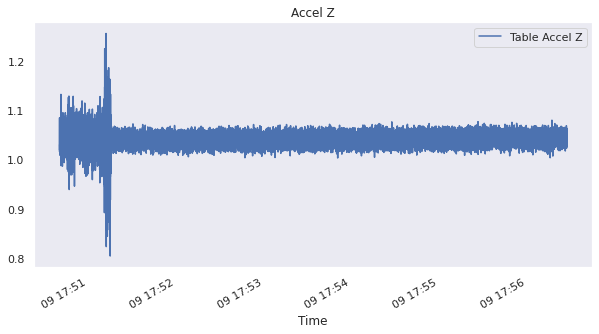

In [7]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
sns.set(color_codes=True)

# set random seed
seed(10)
tf.random.set_seed(10)

# Visualize the data
figsize = (10, 5)
train.iloc[-30000:].plot(x='Time', y='Table Accel Z', figsize=figsize,
           title='Accel Z')
plt.grid()
plt.show()

In [8]:


# Filter only print data
train = train[(train['Time'] >= '2020-11-09 14:44:00.000')
              & (train['Time'] <= '2020-11-09 17:51:00.000')]
# train = train[0:100000]

# Remove Time column
slc = list(range(train.shape[1]))
slc.remove(0)
train_data = train.iloc[:, slc]

# Scale data
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_data))

# Important parameters and training/Test size
prediction_time = 1  # predict just one next value
testdatasize = 1000
unroll_length = 50  # learn from 50 previous values
testdatacut = testdatasize + unroll_length + 1  # = 100501

# Training data
x_train = train_scaled[0:-prediction_time-testdatacut].values
y_train = train_scaled[prediction_time:-testdatacut][0].values

# Test data
x_test = train_scaled[0-testdatacut:-prediction_time].values
y_test = train_scaled[prediction_time-testdatacut:][0].values

# =============================================================
# Beispiel: Sei train_scaled eine Tabelle mit 10.000 Zeilen und 3 Spalten
# df = pd.DataFrame(np.random.randn(10000,3))

# Sei prediction_time = 1, testdatasize = 1000, unroll_length = 50
# testdatacut = 1000 + 50 + 1 = 1051
# x_train: Zeilen 0 bis (9999-1051-1 = 8947); shape: (8948x3)
# y_train: Zeilen 1 bis (9999-1051 = 8948)
# x_test = Zeilen (9999-1051 = 8949) bis (9999-1 = 9998); shape: (1050,3)
# y_test = Zeilen (9999-1050 = 8950) bis 9999
# =============================================================


def unroll(data, sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


# Adapt the datasets for the sequence data shape
x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test = y_test[-x_test.shape[0]:]

# =============================================================
# Beispiel Fortsetzung:
# x_train: Array, der je (unroll_length = 50) aufeinanderfolgende Zeilen
#          der Originalsequenz enthält, also Zeile 0 bis 49,
#          1 bis 50, 2 bis 51, .., 8898 bis 8947
# x_train enthält also 8898 slices der Dimension 50x3
# x_train.shape = (8898, 50, 3)
# =============================================================

# Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)





x_train (967206, 50, 3)
y_train (967206,)
x_test (1000, 50, 3)
y_test (1000,)
compilation time : 0.012450933456420898


In [4]:
# Building the model
model = Sequential()

# im Bsp. oben: x_train.shape[-1] = 3, also Anzahl der Merkmale
model.add(LSTM(units=50, input_dim=x_train.shape[-1],
               return_sequences=True))
model.add(Dropout(0.2))

# model.add(LSTM(100, return_sequences=False))
# model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

NameError: ignored

In [1]:
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=False)

model.fit(x_train, y_train, batch_size=500, epochs=3, validation_split=0.1,
          shuffle=False, callbacks=callbacks_list)

#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

NameError: ignored

In [ ]:


# creating the list of difference between prediction and test data
loaded_model = model
diff = []
ratio = []
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]-pr))

# Plotting the prediction and the reality (for the test data)
plt.figure(figsize=(10, 5))
plt.plot(p, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()